In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_ta as ta
import mplfinance as mpf

In [2]:
# Volatility 10 Index_H1_201901010500_202109010000.csv
df = pd.read_csv('~/Python/projects/mlfin/data/Volatility 10 Index_H1_201901010500_202109010000.csv',
                 encoding='utf-8',
                 index_col=False,
                 skiprows=1,
                 header= None,
                 names= ['date','time','open', 'high', 'low', 'close', 'tv', 'spread'],
                 sep='\t')

df['datetime'] = df['date'] + ' ' + df['time']

df.drop(['date', 'time', 'tv', 'spread'], axis= 1, inplace=True)

df.reset_index(drop=True, inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

/home/sash/Python/projects/mlfin/env/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [3]:
print(df.head())
print()
print(df.info())

                         open      high       low     close
datetime                                                   
2019-01-01 05:00:00  7989.803  7990.783  7981.851  7985.697
2019-01-01 06:00:00  7985.807  7994.125  7984.129  7985.746
2019-01-01 07:00:00  7985.621  7991.298  7979.697  7985.078
2019-01-01 08:00:00  7984.991  7999.997  7983.987  7989.836
2019-01-01 09:00:00  7989.806  7992.654  7983.357  7985.492

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23371 entries, 2019-01-01 05:00:00 to 2021-09-01 00:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    23371 non-null  float64
 1   high    23371 non-null  float64
 2   low     23371 non-null  float64
 3   close   23371 non-null  float64
dtypes: float64(4)
memory usage: 912.9 KB
None


In [4]:
df['vl_oc'] = df['close'] - df['open']

In [5]:
bins = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
df['vl_oc_binned'] = pd.cut(df['vl_oc'], bins)


In [6]:
def add_lags(data, ric, lags, barr=5.1, window=96):
    #cols = []
    dfd = pd.DataFrame(data[ric])
    dfd.dropna(inplace=True)
    #df['r'] = np.log(df / df.shift())
   
    # Простая МА
    dfd['sma'] = dfd[ric].rolling(window).mean()
   
    # Скользящий минимум
    dfd['min'] = dfd[ric].rolling(window).min()
   
    # Скользящий максимум
    dfd['max'] = dfd[ric].rolling(window).max()
   
    # Моментум как среднее значение логарифмической доходности
    #df['mom'] = df['r'].rolling(window).mean()
   
    # Скользящая волатильность
    dfd['vol'] = dfd[ric].rolling(window).std()
    df.dropna(inplace=True)
   
    # Волатильность как бинарный признак
    #dfd['d'] = np.where(abs(dfd[ric]-dfd[ric].shift(-1)) > barr, 1, 0)
    dfd['d'] = np.where(abs(dfd[ric].shift(-1)) > barr, 1, 0)
    #dfd['d'] = np.where(dfd[ric].shift(-1) > 0, 1, 0)
    
    #features = [ric, 'd', 'sma', 'min', 'max', 'vol']
    features = [ric, 'sma', 'min', 'max', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            dfd[col] = dfd[f].shift(lag)
            #cols.append(col)
    
    dfd.dropna(inplace=True)
    return dfd

In [43]:
#lags = 96
lags = 168
barr = 4.9
ric = 'vl_oc'
dfm = add_lags(df, ric, lags)

/tmp/ipykernel_4465/3021111030.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dfd[col] = dfd[f].shift(lag)


In [44]:
#dfm['h'] = dfm.index.hour
#dfm['dow'] = dfm.index.dayofweek

In [45]:
dfm = dfm.dropna()
dfm.head()

,vl_oc,sma,min,max,vol,d,vl_oc_lag_1,vl_oc_lag_2,vl_oc_lag_3,vl_oc_lag_4,...,vol_lag_159,vol_lag_160,vol_lag_161,vol_lag_162,vol_lag_163,vol_lag_164,vol_lag_165,vol_lag_166,vol_lag_167,vol_lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-12 04:00:00,0.080,0.397500,-25.424,27.166,9.214240,0,3.533,-18.648,-0.319,-0.033,...,7.840389,7.833214,7.855290,7.853115,7.873495,7.877921,7.711690,7.585800,7.539480,7.411334
2019-01-12 05:00:00,-1.155,0.650302,-19.906,27.166,8.822959,0,0.080,3.533,-18.648,-0.319,...,7.813267,7.840389,7.833214,7.855290,7.853115,7.873495,7.877921,7.711690,7.585800,7.539480
2019-01-12 06:00:00,4.856,0.751417,-19.906,27.166,8.814867,1,-1.155,0.080,3.533,-18.648,...,7.673197,7.813267,7.840389,7.833214,7.855290,7.853115,7.873495,7.877921,7.711690,7.585800
2019-01-12 07:00:00,-9.882,0.617750,-19.906,27.166,8.878240,1,4.856,-1.155,0.080,3.533,...,7.708526,7.673197,7.813267,7.840389,7.833214,7.855290,7.853115,7.873495,7.877921,7.711690
2019-01-12 08:00:00,-20.066,0.554219,-20.066,27.166,9.004627,1,-9.882,4.856,-1.155,0.080,...,7.703454,7.708526,7.673197,7.813267,7.840389,7.833214,7.855290,7.853115,7.873495,7.877921


In [46]:
#path_to_data = "~/Python/projects/mlfin/data/"
#dfm[['vl_oc', 'd']].to_csv(path_to_data + "dfm.csv")

Теперь делим dfm на обучающую и тестовые выборки и строим модель

In [47]:
dfm_train = dfm[0:20000]
dfm_test = dfm[20000:24022]

In [48]:
X_test = dfm_test.drop(['d'], axis=1)
y_test = dfm_test['d']

In [49]:
print(X_test.shape, y_test.shape)

(3105, 845) (3105,)


In [50]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split

In [51]:

X = dfm_train.drop(['d'], axis=1)
y = dfm_train['d']
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size = 0.30, random_state=42)

In [16]:
#categorial_features = np.where(X_test.dtypes != np.float)[0]
#categorial_features

In [62]:
#learning with train and validation subsets
model = CatBoostClassifier(iterations=1000,
                        depth=6,
                        learning_rate=0.001,
                        custom_loss=['Accuracy'],
                        eval_metric='Accuracy',       
                        verbose=True,
                        random_strength=0.15,
                        use_best_model=True,
                        l2_leaf_reg=3,
                        random_seed=43,
                        task_type='CPU')
model.fit(
    X_train, y_train,
    eval_set = (X_validation, y_validation),
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5635000	test: 0.5252857	best: 0.5252857 (0)	total: 219ms	remaining: 3m 38s
1:	learn: 0.5716667	test: 0.5228571	best: 0.5252857 (0)	total: 458ms	remaining: 3m 48s
2:	learn: 0.5885000	test: 0.5230714	best: 0.5252857 (0)	total: 686ms	remaining: 3m 48s
3:	learn: 0.5978333	test: 0.5279286	best: 0.5279286 (3)	total: 919ms	remaining: 3m 48s
4:	learn: 0.5978333	test: 0.5295000	best: 0.5295000 (4)	total: 1.15s	remaining: 3m 48s
5:	learn: 0.5986667	test: 0.5290714	best: 0.5295000 (4)	total: 1.38s	remaining: 3m 48s
6:	learn: 0.6008333	test: 0.5295000	best: 0.5295000 (4)	total: 1.62s	remaining: 3m 49s
7:	learn: 0.5985000	test: 0.5301429	best: 0.5301429 (7)	total: 1.9s	remaining: 3m 55s
8:	learn: 0.6033333	test: 0.5295000	best: 0.5301429 (7)	total: 2.1s	remaining: 3m 51s
9:	learn: 0.6011667	test: 0.5300714	best: 0.5301429 (7)	total: 2.29s	remaining: 3m 46s
10:	learn: 0.6026667	test: 0.5296429	best: 0.5301429 (7)	total: 2.48s	remaining: 3m 43s
11:	learn: 0.6051667	test: 0.5305000	best: 0

In [63]:
prediction = model.predict(X_validation)
proba = model.predict_proba(X_validation)
print(prediction[120:125])
print(proba[120:125])

[1 1 1 1 1]
[[0.48410125 0.51589875]
 [0.48162488 0.51837512]
 [0.48605154 0.51394846]
 [0.4906311  0.5093689 ]
 [0.47985936 0.52014064]]


In [64]:
from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(y_validation, prediction, normalize='true')
print(cfm)

[[0.37275405 0.62724595]
 [0.30291262 0.69708738]]


In [65]:
prediction_t = model.predict(X_test)
cfm_t = confusion_matrix(y_test, prediction_t)
print(cfm_t)

[[1260  415]
 [1047  383]]


In [66]:
a= 1260 + 383
b = 1047 + 415

print(a)
print (b)
print(a/b)

1643
1462
1.1238030095759235


In [67]:
from catboost.utils import get_roc_curve
from sklearn.metrics import auc

In [68]:
validate_pool = Pool(X_validation, y_validation)
test_pool = Pool(X_test, y_test)

In [69]:
curve = get_roc_curve(model, validate_pool)
(fpr, tpr, thresholds) = curve
roc_auc = auc(fpr, tpr)
roc_auc

0.5409346983713914

In [70]:
curve = get_roc_curve(model, test_pool)
(fpr, tpr, thresholds) = curve
roc_auc = auc(fpr, tpr)
roc_auc

0.5218778833107192

In [63]:
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'Accuracy',
    'custom_metric': 'F1',
    'random_seed': 43,
    'logging_level': 'Silent'
}

In [64]:
train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_validation, y_validation)

In [65]:
# Тут выводился график, для VSCode график отключил
modelt = CatBoostClassifier(**params)
modelt.fit(train_pool, eval_set=validate_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
modelt.save_model('model.py', format='python', pool=train_pool)

In [66]:
modelt.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Accuracy',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'class_names': [0, 1],
 'random_seed': 43,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'custom_metric': ['F1'],
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.04932999983429909,
 'score_function': 'Cos

In [67]:
from catboost.utils import get_roc_curve
from sklearn.metrics import auc

In [68]:
curve = get_roc_curve(modelt, validate_pool)
(fpr, tpr, thresholds) = curve
roc_auc = auc(fpr, tpr)
roc_auc

0.5297800905385543

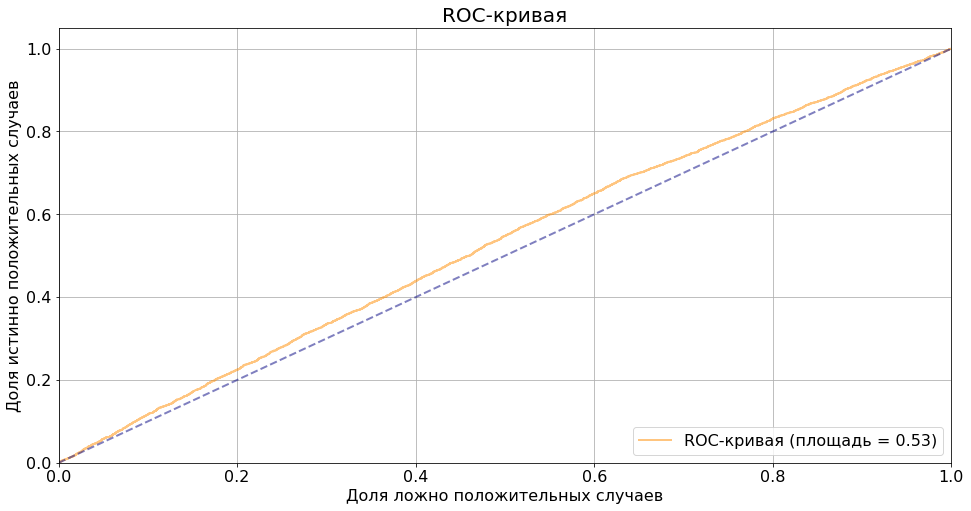

In [69]:
plt.figure(figsize=(16, 8))
lw=2
plt.plot (fpr, tpr, color='darkorange',
         lw=lw, label='ROC-кривая (площадь = %0.2f)' % roc_auc, alpha=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Доля ложно положительных случаев', fontsize=16)
plt.ylabel('Доля истинно положительных случаев', fontsize=16)
plt.title('ROC-кривая', fontsize=20)
plt.legend(loc='lower right', fontsize=16)
plt.show()

In [72]:
m_param = model.get_feature_importance(train_pool,
                            fstr_type='PredictionValuesChange',
                            prettified=True)

In [71]:
type(m_param)

pandas.core.frame.DataFrame

In [73]:
m_param.to_csv('/home/sash/Python/projects/mlfin/data/model_param.csv')